# Investigating adjusted p-values from eQTL analysis

__Author:__ Bryan Quach  
__Date:__ April 27, 2017

### Estimated Analysis Time: <1 days

## Objective

There are multiple objectives of this analysis. The main goal is to apply multiple testing correction to the initial results of the eQTL analyses (unadjusted p-values). Following the multiple testing correction, we will address the following questions:

* What is the q-value distribution of our results?
* How many gene-marker pairs produced a significant association?
* How many statistically significant eQTL-containing genes (eGenes) are observed?
* Which gene and marker comparisons produced the most significant hits?
* Which genes tested are eGenes?

## Software required

* [dplyr (R package)](https://cran.r-project.org/web/packages/dplyr/index.html)
* [qvalue (R package)](https://www.bioconductor.org/packages/release/bioc/html/qvalue.html)
* [GenomicRanges (R package)](https://bioconductor.org/packages/release/bioc/html/GenomicRanges.html)

## The Data

The data that we work with are results output from running a modified version of Daniel Oreper's eQTL analysis software. This software produces an R data file containing the environment in which the analysis was run, which includes a matrix of p-values with rows and columns corresponding to genes and markers respectively. In this analysis, we will look at results for the eQTL analyses in lung, liver, and kidney control samples. The phenotype used for the eQTL analysis was DESeq2 normalized (median ratio normalized) TPM values. These were also the values used to filter out lowly expressed genes.

## Global multiple testing correction

We apply [FDR correction](https://en.wikipedia.org/wiki/False_discovery_rate) to the p-values from all association tests. The resulting q-values will be used for assessing significance of all gene-marker pairs at a specified threshold. To aid in data analysis, we will convert our matrices of p-values into a data frame with `NA` values removed.

In [1]:
library(dplyr)
library(qvalue)
library(GenomicRanges)

# Function for retrieving non-NA values from matrix
#
# Args:
#   haystack - matrix to search through
#
# Returns a dataframe of the p-values with gene and marker names listed
reshape.results <- function(haystack){
    hits <- which(!is.na(haystack), arr.ind=T)
    rnames <- rownames(haystack)[hits[,1]]
    cnames <- colnames(haystack)[hits[,2]]    
    pvals <- sapply(1:nrow(hits), function(i){haystack[hits[i,1], hits[i,2]]})
    results <- data.frame(gene=rnames, marker=cnames, pval=as.numeric(pvals))
    results <- results[order(results$gene),]
    return(results)
}

#Get p-value matrices for each tissue
tmp.env <- new.env()
load("data/control_lung.Rdata", envir=tmp.env)
matrix.lung <- get("out.mat", tmp.env)
load("data/control_liver.Rdata", envir=tmp.env)
matrix.liver <- get("out.mat", tmp.env)
load("data/control_kidney.Rdata", envir=tmp.env)
matrix.kidney <- get("out.mat", tmp.env)
rm(tmp.env)

#Reshape
pvals.lung <- reshape.results(matrix.lung)
pvals.liver <- reshape.results(matrix.liver)
pvals.kidney <- reshape.results(matrix.kidney)

#Apply FDR correction
qvals.lung <- qvalue(pvals.lung$pval, fdr.level=0.1) 
qvals.liver <- qvalue(pvals.liver$pval, fdr.level=0.1)
qvals.kidney <- qvalue(pvals.kidney$pval, fdr.level=0.1)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Identifying significant eGenes

For downstream analyses that focus only on the gene-level results, we will assign a representative p-value for each gene. A common approach to do this is to use the smallest p-value for a gene across tests as a test statistic. A permutation test is then applied where the gene expression values are permuted, and a p-value is derived from this permutation test procedure. Because this is computationally too expensive given our current resources, we will instead apply [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction) to the p-values from each marker test with a gene. In this approach we tabulate the number of tests performed for each gene then multiply each p-value by that number. We will use the smallest Bonferroni corrected p-value as the representative p-value for a gene. We will then account for multiple comparisons across genes by appyling FDR correction.

In [3]:
#Apply Bonferroni correction
matrix.adj.lung <- matrix.lung * apply(matrix.lung,1,function(x){length(which(!is.na(x)))})
matrix.adj.liver <- matrix.liver * apply(matrix.liver,1,function(x){length(which(!is.na(x)))})
matrix.adj.kidney <- matrix.kidney * apply(matrix.kidney,1,function(x){length(which(!is.na(x)))})

#Apply value ceiling of 1 to p-values
matrix.adj.lung <- apply(matrix.adj.lung, 2, function(x){ifelse(x>1,1,x)})
matrix.adj.liver <- apply(matrix.adj.liver, 2, function(x){ifelse(x>1,1,x)})
matrix.adj.kidney <- apply(matrix.adj.kidney, 2, function(x){ifelse(x>1,1,x)})

#Assign representative p-value to each gene
gene.pval.lung <- apply(matrix.adj.lung, 1, min, na.rm=T)
if(length(which(gene.pval.lung==Inf))>0){ gene.pval.lung <- gene.pval.lung[-1*which(gene.pval.lung==Inf)] }
gene.pval.liver <- apply(matrix.adj.liver, 1, min, na.rm=T)
if(length(which(gene.pval.liver==Inf))>0){ gene.pval.liver <- gene.pval.liver[-1*which(gene.pval.liver==Inf)] }
gene.pval.kidney <- apply(matrix.adj.kidney, 1, min, na.rm=T)
if(length(which(gene.pval.kidney==Inf))>0){ gene.pval.kidney <- gene.pval.kidney[-1*which(gene.pval.kidney==Inf)] }

#Apply FDR correction
gene.qval.lung <- qvalue(p=gene.pval.lung, fdr.level=0.1)
gene.qval.liver <- qvalue(p=gene.pval.liver, fdr.level=0.1)
gene.qval.kidney <- qvalue(p=gene.pval.kidney, fdr.level=0.1)

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”

## Plotting statistics

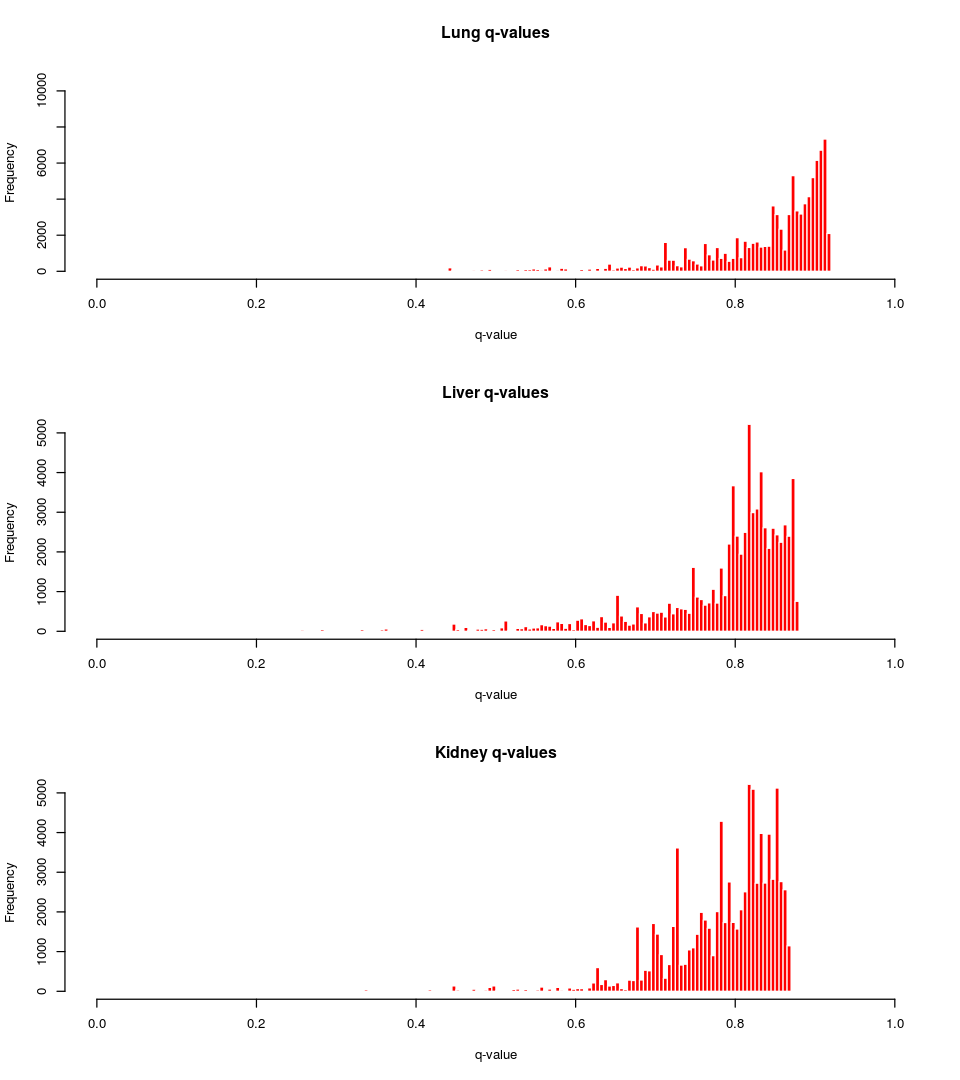

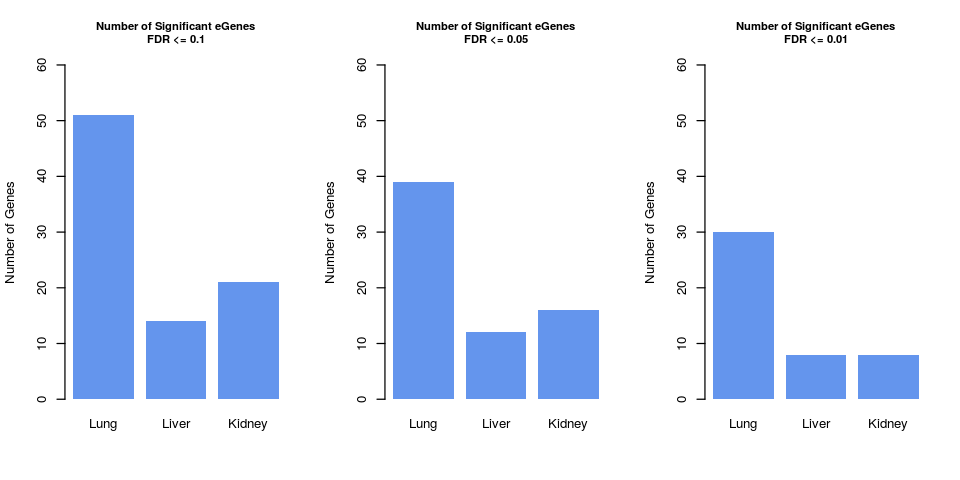

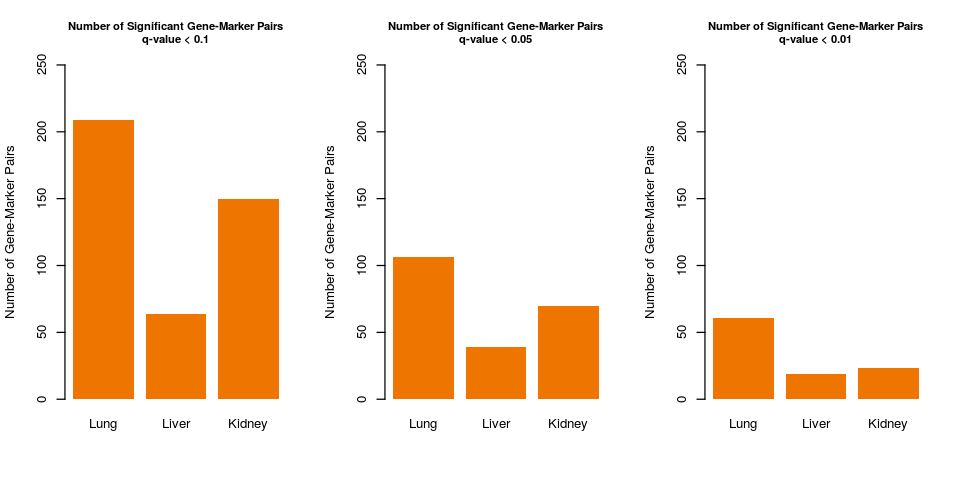

In [5]:
library(repr)

#P-value distributions
options(repr.plot.width=8, repr.plot.height=9)
par(mfrow=c(3,1))
hist(as.numeric(qvals.lung$qvalues), breaks=200, freq=T, ylim=c(0,11000), xlim=c(0,1),
     col="red", border="white",
     main="Lung q-values",
     ylab="Frequency",
     xlab="q-value")
hist(as.numeric(qvals.liver$qvalues), breaks=200, freq=T, ylim=c(0,5000), xlim=c(0,1),
     col="red", border="white",
     main="Liver q-values",
     ylab="Frequency", 
     xlab="q-value")
hist(as.numeric(qvals.kidney$qvalues), breaks=200, freq=T, ylim=c(0,5000), xlim=c(0,1),
     col="red", border="white",
     main="Kidney q-values",
     ylab="Frequency", 
     xlab="q-value")


#Calculate significant eGenes and gene marker pairs
for(cutoff in c(0.1,0.05,0.01)){
    num.egenes.lung <- length(which(gene.qval.lung$qvalues<cutoff))
    num.egenes.liver <- length(which(gene.qval.liver$qvalues<cutoff))
    num.egenes.kidney <- length(which(gene.qval.kidney$qvalues<cutoff))
    assign(x=paste0("num.egenes.",cutoff),value=c(num.egenes.lung, num.egenes.liver, num.egenes.kidney))

    num.sig.lung <- length(which(qvals.lung$qvalues<cutoff))
    num.sig.liver <- length(which(qvals.liver$qvalues<cutoff))
    num.sig.kidney <- length(which(qvals.kidney$qvalues<cutoff))
    assign(x=paste0("num.sig.",cutoff),value=c(num.sig.lung, num.sig.liver, num.sig.kidney))
}

#Significant eGenes
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,3))
barplot(height=num.egenes.0.1, beside=T, ylab="Number of Genes", ylim=c(0,60),
        border=NA, col="cornflowerblue",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant eGenes\nFDR <= 0.1",
        cex.main=0.85)
barplot(height=num.egenes.0.05, beside=T, ylab="Number of Genes", ylim=c(0,60),
        border=NA, col="cornflowerblue",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant eGenes\nFDR <= 0.05",
        cex.main=0.85)
barplot(height=num.egenes.0.01, beside=T, ylab="Number of Genes", ylim=c(0,60),
        border=NA, col="cornflowerblue",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant eGenes\nFDR <= 0.01",
        cex.main=0.85)


#Significant gene marker paris
par(mfrow=c(1,3))
barplot(height=num.sig.0.1, beside=T, ylab="Number of Gene-Marker Pairs", ylim=c(0,250),
        border=NA, col="darkorange2",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant Gene-Marker Pairs\nq-value < 0.1",
        cex.main=0.85)
barplot(height=num.sig.0.05, beside=T, ylab="Number of Gene-Marker Pairs", ylim=c(0,250),
        border=NA, col="darkorange2",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant Gene-Marker Pairs\nq-value < 0.05",
        cex.main=0.85)
barplot(height=num.sig.0.01, beside=T, ylab="Number of Gene-Marker Pairs", ylim=c(0,250),
        border=NA, col="darkorange2",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant Gene-Marker Pairs\nq-value < 0.01",
        cex.main=0.85)

## Retrieving most significant associations

For each tissue, we retrieve the 100 gene-marker pairs that produced the most significant q-values and list them below. Notably, not all the records listed have q-values that would pass typical thresholds.

In [6]:
#Load marker coordinates and gene expression data
tmp.env <- new.env()
load("data/control_lung.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
rna.levels.lung <- tmp.data$exp.mat
marker.map <- tmp.data$marker.map
load("data/control_liver.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
rna.levels.liver <- tmp.data$exp.mat
load("data/control_kidney.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
rna.levels.kidney <- tmp.data$exp.mat
rm(tmp.env, tmp.data)

#Make data frame of sorted results and subset
lung.list <- cbind(pvals.lung, qval=qvals.lung$qvalues)
lung.list <- lung.list[order(lung.list$qval),]
liver.list <- cbind(pvals.liver, qval=qvals.liver$qvalues)
liver.list <- liver.list[order(liver.list$qval),]
kidney.list <- cbind(pvals.kidney, qval=qvals.kidney$qvalues)
kidney.list <- kidney.list[order(kidney.list$qval),]
top.lung.list <- lung.list[1:100,]
top.liver.list <- liver.list[1:100,]
top.kidney.list <- kidney.list[1:100,]

#Get genomic coordinates for top markers
get.location <- function(marker, marker.map){
    boundary.markers <- unlist(strsplit(x=marker, split=".", fixed=T))
    m.index1 <- which(marker.map$marker==boundary.markers[1])
    m.index2 <- which(marker.map$marker==boundary.markers[2])
    if(length(m.index1)!=1 | length(m.index2)!=1){
        error_msg <- paste0("Error: Marker not found in marker map: ", marker)
        stop(error_msg)
    }
    #Get marker region
    m1 <- marker.map[m.index1,]
    m2 <- marker.map[m.index2,]
    if(m1$chromosome!=m2$chromosome){stop("Error: Markers merged across chromosomes!")}
    m.region <- c(m1$chromosome, m1$position, m2$position)
    return(m.region)
}
top.lung.list <- cbind(top.lung.list, t(sapply(as.character(top.lung.list$marker), get.location, marker.map=marker.map)))[,c(1,2,5,6,7,3,4)]
top.liver.list <- cbind(top.liver.list, t(sapply(as.character(top.liver.list$marker), get.location, marker.map=marker.map)))[,c(1,2,5,6,7,3,4)]
top.kidney.list <- cbind(top.kidney.list, t(sapply(as.character(top.kidney.list$marker), get.location, marker.map=marker.map)))[,c(1,2,5,6,7,3,4)]
colnames(top.lung.list)[3:5] <- c("chr", "start", "end")
colnames(top.liver.list)[3:5] <- c("chr", "start", "end")
colnames(top.kidney.list)[3:5] <- c("chr", "start", "end")

#Get gene expression statistics
gene.calc <- function(gene, expression){
    abundance <- expression[,colnames(expression)==gene]
    return(c(mean(abundance), sd(abundance), range(abundance)))
}
gene.stats.lung <- t(sapply(top.lung.list$gene, gene.calc, expression=rna.levels.lung))
gene.stats.liver <- t(sapply(top.liver.list$gene, gene.calc, expression=rna.levels.liver))
gene.stats.kidney <- t(sapply(top.kidney.list$gene, gene.calc, expression=rna.levels.kidney))
top.lung.list <- cbind(top.lung.list, gene.stats.lung)
top.liver.list <- cbind(top.liver.list, gene.stats.liver)
top.kidney.list <- cbind(top.kidney.list, gene.stats.kidney)
colnames(top.lung.list)[8:11] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.liver.list)[8:11] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.kidney.list)[8:11] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")

#Display tables
cat("Lung\n")
top.lung.list
cat("Liver\n")
top.liver.list
cat("Kidney\n")
top.kidney.list

#Write tables to file
write.table(x=top.lung.list, file="results/lung_top100_hits_adjusted_pvals.txt", 
            quote=F, row.names=F, col.names=T, sep="\t")
write.table(x=top.liver.list, file="results/liver_top100_hits_adjusted_pvals.txt", 
            quote=F, row.names=F, col.names=T, sep="\t")
write.table(x=top.kidney.list, file="results/kidney_top100_hits_adjusted_pvals.txt", 
            quote=F, row.names=F, col.names=T, sep="\t")


Lung


gene     marker                         chr   start     end      
690   AI597479 UNC533184.UNC536663            chr1  42075848  42338285 
694   AI597479 UNC536810.JAX00248660          chr1  42350732  42376832 
735   AI597479 UNC550060.UNC557806            chr1  43289978  43742556 
704   AI597479 JAX00248770.UNC547234          chr1  42708016  43093838 
713   AI597479 JAX00248843.JAX00248843        chr1  43103831  43103831 
722   AI597479 UNC547351.UNC549896            chr1  43107520  43272443 
698   AI597479 JAX00248662.UNC541737          chr1  42383626  42688637 
34262 Tmem147  UNC12572462.UNC12573732        chr7  31229864  31312408 
34258 Sdhaf1   UNC12572462.UNC12573732        chr7  31229864  31312408 
550   Sema4c   JAX00002582.UNC474632          chr1  37614784  38262134 
34227 Gapdhs   UNC12572462.UNC12573732        chr7  31229864  31312408 
22889 Gm3414   UNC9076911.UNC9083687          chr5  45151477  45681428 
34260 Syne4    UNC12572462.UNC12573732        chr7  31229864  31312408 
21982 Srpk2    UNC8769425.UNC8791233          chr5  21016194  22478235 
921   Bzw1     UNC718116.UNC734946            chr1  56309822  57836503 
22801 Zbtb49   UNC8990872.UNC8994596          chr5  38811294  39057615 
774   Dnah7c   UNC578793.UNC597735            chr1  45313373  46963812 
21977 Ptpn12   UNC8769425.UNC8791233          chr5  21016194  22478235 
21952 Ptpn12   UNC8760878.UNC8769129          chr5  20434895  21005163 
21920 Ptpn12   UNC8744830.UNC8757015          chr5  19273068  20112984 
21936 Ptpn12   UNC8757558.UNC8760307          chr5  20151188  20378767 
33306 Mia      UNC12521377.UNC12521377        chr7  27033384  27033384 
924   Fam126b  UNC718116.UNC734946            chr1  56309822  57836503 
22825 C1qtnf7  UNC9041493.UNC9052705          chr5  42639446  43555880 
22835 C1qtnf7  UNC9053052.JAX00580480         chr5  43582364  44035155 
22845 C1qtnf7  UNC9060026.UNC9064193          chr5  44075539  44331121 
34069 Paf1     UNC12549403.UNC12567534        chr7  29589840  30930206 
33969 Paf1     UNC12543724.UNC12548710        chr7  29110157  29536489 
33828 Paf1     UNC12542093.UNC12543129        chr7  28910807  29040349 
33898 Paf1     UNC12543518.UNC12543518        chr7  29082051  29082051 
⋮     ⋮        ⋮                              ⋮     ⋮         ⋮        
33919 Timm50   UNC12543518.UNC12543518        chr7  29082051  29082051 
77935 Olfr172  UNC26908820.UNC26909630        chr16 58562352  58660429 
34096 Timm50   UNC12549403.UNC12567534        chr7  29589840  30930206 
747   Tpp2     UNC550060.UNC557806            chr1  43289978  43742556 
767   Tpp2     JAX00249009.UNC577593          chr1  43743194  45188002 
66959 Nhlrc1   UNC22553195.UNC22578692        chr13 47325689  50588947 
33991 Timm50   UNC12543724.UNC12548710        chr7  29110157  29536489 
719   Tpp2     JAX00248843.JAX00248843        chr1  43103831  43103831 
732   Tpp2     UNC547351.UNC549896            chr1  43107520  43272443 
710   Tpp2     JAX00248770.UNC547234          chr1  42708016  43093838 
33806 Gm10046  UNC12542093.UNC12543129        chr7  28910807  29040349 
88609 Stx5a    UNC29871907.JAX00470016        chr19 9096225   9111146  
33881 Gm10046  UNC12543518.UNC12543518        chr7  29082051  29082051 
53263 Nemp1    UNC18963682.JAX00302406        chr10 127267455 127919711
23024 Sepsecs  UNC9178955.JAX00582322         chr5  52428319  52568625 
23092 Sepsecs  UNC9194356.JAX00582642         chr5  53474988  53501844 
53092 Nemp1    UNC18954707.UNC18961845        chr10 126429359 127050365
53337 Nemp1    UNC18970636.UNC101328991       chr10 127924035 128389507
53171 Nemp1    JAX00302230.UNC18963675        chr10 127068725 127267133
23011 Sepsecs  UNC9178217.UNC9178793          chr5  52373198  52417094 
88565 Stx5a    UNC29871593.UNC29871593        chr19 9054951   9054951  
50892 Psap     UNC18034355.JAX00290458        chr10 58371317  59481957 
22902 Lcorl    UNC9084229.JAX00129566         chr5  45729526  46516239 
50918 Psap     UNC18049832.JAX00290510        

Liver


gene     marker                        chr   start     end      
17353 Wdr1     UNC8995230.UNC9018866         chr5  39098969  40848041 
48803 Grhl1    JAX00327915.JAX00327915       chr12 25912290  25912290 
619   Ankrd44  UNC699866.JAX00003956         chr1  54864353  55969159 
62076 Haghl    UNC27706510.UNC27714988       chr17 26211004  26777986 
62130 Haghl    UNC27715265.UNC27718914       chr17 26794469  27125532 
33492 Cklf     UNC15401027.JAX00679070       chr8  105224029 106423866
33508 Cklf     UNC15416961.JAX00679081       chr8  106429699 106464668
33531 Cklf     UNC15417874.UNC15422538       chr8  106499195 106863747
33572 Cklf     UNC15422872.UNC15444168       chr8  106893004 109080134
5887  G6pc2    UNC3274971.UNC3298947         chr2  69171715  70960464 
48795 Grhl1    UNC20742271.JAX00199937       chr12 25878188  25907076 
10078 Npr1     UNC5732520.UNC5752814         chr3  88658882  91515928 
61994 Haghl    UNC27694572.JAX00434363       chr17 25154006  26173928 
61895 Haghl    UNC170299097.UNC27694074      chr17 23782631  25086028 
51231 Hist1h1e UNC22234794.UNC22263112       chr13 20735950  23717824 
51302 Hist1h1e UNC22263703.UNC22267580       chr13 23772752  24032419 
48777 Grhl1    JAX00327082.JAX00327882       chr12 17162103  25866746 
51842 Nfil3    JAX00357912.JAX00357963       chr13 52194752  52291750 
5830  G6pc2    UNC3268533.JAX00095547        chr2  68747260  68915300 
51829 Nfil3    UNC22578796.UNC22595965       chr13 50622298  52163074 
30995 Abhd13   UNC14155073.UNC14155073       chr8  10943206  10943206 
5867  G6pc2    UNC3274478.UNC3274700         chr2  69129193  69149592 
5121  Gtf3c4   UNC2788440.UNC2804046         chr2  27800459  28980447 
5089  Gtf3c4   UNC2783477.UNC2788235         chr2  27449877  27790189 
30980 Abhd13   JAX00158787.UNC14154785       chr8  10499490  10922599 
5849  G6pc2    UNC3271429.UNC3273914         chr2  68942586  69092084 
10065 Ints3    UNC5732520.UNC5752814         chr3  88658882  91515928 
30970 Abhd13   UNC14124729.UNC14147606       chr8  9026072   10474095 
677   Clk1     UNC738685.UNC739718           chr1  58127044  58197917 
698   Clk1     JAX00252106.UNC741530         chr1  58241774  58313335 
⋮     ⋮        ⋮                             ⋮     ⋮         ⋮        
15041 Fuca1    JAX00567935.JAX00567935       chr4  136040465 136040465
15071 Fuca1    UNC8300204.UNC8301426         chr4  136065318 136177466
48820 Grhl1    UNC20742915.UNC20748671       chr12 25926950  26314924 
39969 Hsp90b1  JAX00294363.UNC18356578       chr10 84260234  85190114 
45708 Nr1d1    UNC20208047.UNC20210453       chr11 97524179  97738186 
45994 Nr1d1    UNC20229820.UNC20233664       chr11 99311694  99545647 
5035  Snora17  UNC2774912.JAX00485829        chr2  26838197  27087825 
5072  Snora17  UNC2778287.UNC2783098         chr2  27095969  27426000 
45931 Thra     UNC20219482.UNC20219482       chr11 98520274  98520274 
45972 Thra     UNC20220061.JAX00319724       chr11 98555630  99279520 
46001 Thra     UNC20229820.UNC20233664       chr11 99311694  99545647 
46030 Thra     UNC20234075.UNC20234075       chr11 99588306  99588306 
45895 Thra     JAX00319556.UNC20219195       chr11 98437895  98505069 
7831  Dnmt3b   UNC4267378.UNC4298342         chr2  154311491 156994824
6877  Mir3473g UNC020188428.UNC020188428     chr2  127338536 127338536
6902  Mir3473g UNC3930995.UNC3932319         chr2  127354148 127444453
6928  Mir3473g UNC3932612.UNC3936541         chr2  127471844 127779562
15103 Fuca1    UNC8302213.UNC8307036         chr4  136220469 136532463
39986 Hsp90b1  UNC18356716.UNC18357001       chr10 85214949  85308382 
10090 Rrnad1   UNC5732520.UNC5752814         chr3  88658882  91515928 
45956 Nr1d1    UNC20220061.JAX00319724       chr11 98555630  99279520 
6852  Mir3473g UNC3927435.UNC3930347         chr2  127071778 127310578
45801 Nr1d1    B6_11_097849250_S.UNC20216486 chr11 97849250  98277322 
45916 Nr1d1    UNC20219482.UNC20219482       chr11 98520274  98520274 
14973 Fuca1    JAX00567771.UNC

Kidney


gene          marker                         chr   start     end      
47703 Pmel          JAX00302230.UNC18963675        chr10 127068725 127267133
47796 Pmel          UNC18963682.JAX00302406        chr10 127267455 127919711
47870 Pmel          UNC18970636.UNC101328991       chr10 127924035 128389507
47931 Pmel          JAX00302462.JAX00302527        chr10 128394706 128919120
47963 Pmel          UNC18980143.UNC18983661        chr10 128988719 129385947
23366 Cux1          UNC10243742.UNC10244171        chr5  136017898 136044478
6476  Fam78a        UNC2843756.UNC2845489          chr2  32823325  33056993 
41045 Siae          UNC16177202.UNC16189957        chr9  37440457  38326154 
41058 Siae          UNC16190786.JAX00691017        chr9  38399972  39681162 
6432  Fam78a        JAX00486759.UNC2842985         chr2  32759265  32766136 
6273  Fam78a        UNC2824282.UNC021013288        chr2  30857727  32090328 
6341  Fam78a        UNC2837330.UNC2838381          chr2  32143261  32279051 
6386  Fam78a        JAX00486705.UNC2842526         chr2  32312092  32727326 
23734 Get4          UNC10291007.UNC10306321        chr5  139780797 140933260
74285 Gtf2f1        UNC28065431.UNC28072598        chr17 55961701  56761009 
41029 Siae          UNC16167936.UNC16176492        chr9  36736917  37377135 
56897 Cys1          JAX00328078.UNC20759206        chr12 26315861  26975745 
57283 Gm527         UNC21287287.UNC21302151        chr12 66506122  67653356 
74341 Gtf2f1        UNC170254792.JAX00442513       chr17 56796579  57033138 
41010 Siae          UNC16155946.JAX00690419        chr9  35421582  36669652 
71781 Pde10a        UNC27534981.UNC27536218        chr17 8537587   8650044  
84836 Ssr4          UNC30955632.UNC30964860        chrX  69659188  71097310 
17944 Mir6399       UNC8323552.UNC8325248          chr4  137691029 137811542
26069 2310069B03Rik JAX00615510.UNC11497618        chr6  81832436  82891081 
26107 2310069B03Rik UNC11498802.UNC11507375        chr6  82981686  83698198 
14908 Exosc3        UNC7170328.JAX00549865         chr4  45963634  46066550 
14935 Exosc3        UNC7171512.UNC7178019          chr4  46071332  46550736 
67165 Fam19a5       UNC26040510.UNC26042016        chr15 86696492  86801573 
56757 Fam49a        UNC20624337.UNC20639168        chr12 11157678  12265687 
66445 Npcd          JAX00406581.UNC25941426        chr15 78344275  78763276 
⋮     ⋮             ⋮                              ⋮     ⋮         ⋮        
7858  B2m           UNC3842618.UNC3869677          chr2  119359940 122155355
7943  B2m           UNC020174288.UNC020174288      chr2  122225711 122225711
7968  B2m           UNC3870640.JAX00502183         chr2  122231584 124801343
62829 Capn7         UNC23798735.UNC23812618        chr14 32772050  33750457 
15634 Lepr          JAX00559813.JAX00559813        chr4  101171953 101171953
22831 Bcl7a         UNC10063577.JAX00595174        chr5  123430175 123451903
22748 Bcl7a         UNC10052841.UNC10061728        chr5  122564482 123298769
62787 Capn7         JAX00376591.UNC23798374        chr14 32256264  32750042 
10063 Gm14288       UNC4556542.UNC4558476          chr2  174406645 174549940
62706 Capn7         UNC23782743.UNC23787821        chr14 31296602  31754282 
62743 Capn7         UNC23788140.UNC23792603        chr14 31778366  32228156 
67190 Fam19a5       JAX00064686.UNC26057169        chr15 87819378  87830541 
85465 Gla           UNC31339434.UNC31340189        chrX  130670713 130773327
85569 Gla           UNC31344134.JAX00719373        chrX  131252905 131415088
85598 Gla           UNC31346472.UNC31347593        chrX  131499737 131613048
85624 Gla           UNC31348015.backupUNC200692256 chrX  131731006 131739943
1068  Nrp2          UNC790025.UNC791840            chr1  62671648  62831748 
36962 Plpp5         JAX00663556.UNC14333584        chr8  25991615  26038735 
36980 Plpp5         UNC14334524.UNC14334524        chr8  26092501  26092501 
37001 Plpp5         UNC14334951.JAX00159821        chr8  26133140  26264908 
37

## Retrieving significant eGenes

For each tissue, we retrieve significant eGenes (FDR <= 0.1) and list them below.

In [9]:
#Load gene coordinates
tmp.env <- new.env()
load("data/control_lung.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
gene.map <- tmp.data$cis.map #GenomicRanges object
rm(tmp.env, tmp.data)

#Make data frame of sorted results and subset
lung.gene.list <- data.frame(gene.pval.lung, qval=gene.qval.lung$qvalues)
lung.gene.list <- lung.gene.list[order(lung.gene.list$qval),]
liver.gene.list <- data.frame(gene.pval.liver, qval=gene.qval.liver$qvalues)
liver.gene.list <- liver.gene.list[order(liver.gene.list$qval),]
kidney.gene.list <- data.frame(gene.pval.kidney, qval=gene.qval.kidney$qvalues)
kidney.gene.list <- kidney.gene.list[order(kidney.gene.list$qval),]
colnames(lung.gene.list) <- c("pval","qval")
colnames(liver.gene.list) <- c("pval","qval")
colnames(kidney.gene.list) <- c("pval","qval")
top.genes.lung <- lung.gene.list[which(lung.gene.list$qval<=0.1),]
top.genes.liver <- liver.gene.list[which(liver.gene.list$qval<=0.1),]
top.genes.kidney <- kidney.gene.list[which(kidney.gene.list$qval<=0.1),]

#Get gene locations
locations.lung <- sapply(rownames(top.genes.lung), function(x, map){as.character(map[which(map$gene==x),])}, map=gene.map)
locations.liver <- sapply(rownames(top.genes.liver), function(x, map){as.character(map[which(map$gene==x),])}, map=gene.map)
locations.kidney <- sapply(rownames(top.genes.kidney), function(x, map){as.character(map[which(map$gene==x),])}, map=gene.map)
top.genes.lung <- cbind(top.genes.lung, locations.lung)
top.genes.liver <- cbind(top.genes.liver, locations.liver)
top.genes.kidney <- cbind(top.genes.kidney, locations.kidney)
colnames(top.genes.lung)[3] <- "coordinate"
colnames(top.genes.liver)[3] <- "coordinate"
colnames(top.genes.kidney)[3] <- "coordinate"

#Get gene expression statistics
gene.stats.lung <- t(sapply(rownames(top.genes.lung), gene.calc, expression=rna.levels.lung))
gene.stats.liver <- t(sapply(rownames(top.genes.liver), gene.calc, expression=rna.levels.liver))
gene.stats.kidney <- t(sapply(rownames(top.genes.kidney), gene.calc, expression=rna.levels.kidney))
top.genes.lung <- cbind(top.genes.lung, gene.stats.lung)
top.genes.liver <- cbind(top.genes.liver, gene.stats.liver)
top.genes.kidney <- cbind(top.genes.kidney, gene.stats.kidney)
colnames(top.genes.lung)[4:7] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.genes.liver)[4:7] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.genes.kidney)[4:7] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")


#Display tables
cat("Lung\n")
top.genes.lung
cat("Liver\n")
top.genes.liver
cat("Kidney\n")
top.genes.kidney

#Write tables to file
write.table(x=top.genes.lung, file="results/lung_egenes.txt", 
            quote=F, row.names=T, col.names=T, sep="\t")
write.table(x=top.genes.liver, file="results/liver_egenes.txt", 
            quote=F, row.names=T, col.names=T, sep="\t")
write.table(x=top.genes.kidney, file="results/kidney_egenes.txt", 
            quote=F, row.names=T, col.names=T, sep="\t")


Lung


pval         qval         coordinate                mean.expression
AI597479 1.287388e-85 2.275845e-81 chr1:42155554-44155555     20.3219299    
Tmem147  4.529089e-42 4.003262e-38 chr7:30514552-32514553     46.4101646    
Sdhaf1   3.415757e-39 2.012792e-35 chr7:30107393-32107394     14.5279333    
Sema4c   6.888370e-21 3.044315e-17 chr1:35615225-37615226     16.3055888    
Gapdhs   4.692262e-20 1.658996e-16 chr7:30528699-32528700      3.0851197    
Gm3414   9.966740e-20 2.936534e-16 chr5:45118816-47118817      7.3925290    
Syne4    3.543964e-19 8.950028e-16 chr7:30099834-32099835      3.6918125    
Srpk2    1.934153e-12 4.273996e-09 chr5:22122388-24122389     30.3884229    
Bzw1     2.986040e-11 5.865246e-08 chr1:57449979-59449980    109.1228354    
Zbtb49   6.780825e-11 1.198714e-07 chr5:37611666-39611667      5.4897899    
Dnah7c   1.049206e-10 1.686170e-07 chr1:45482362-47482363      3.4998949    
Ptpn12   7.595551e-10 1.118951e-06 chr5:19561614-21561615     66.8040148    
C1qtnf7  3.342946e-09 4.545893e-06 chr5:42906807-44906808     47.9835679    
Fam126b  4.236377e-09 5.349333e-06 chr1:57643176-59643177     22.8165988    
Mia      5.549701e-09 6.540508e-06 chr7:26966167-28966168      2.6943453    
Paf1     1.111986e-08 1.228606e-05 chr7:28178014-30178015     49.0298200    
Sf3b1    1.812675e-08 1.884969e-05 chr1:54084321-56084322    141.5331300    
Ormdl1   5.423633e-08 5.326610e-05 chr1:52353938-54353939     15.8152328    
Fbl      6.459171e-07 6.009749e-04 chr7:27954766-29954767     32.0993516    
Slc39a10 1.204381e-06 1.064553e-03 chr1:45910353-47910354     21.0196669    
Mir7212  2.772099e-06 2.333579e-03 chr15:24877981-26877982     1.0597321    
Osgepl1  3.073317e-06 2.469550e-03 chr1:52370467-54370468     12.1762195    
Sgpp1    5.235901e-06 4.024359e-03 chr12:75836715-77836716    31.1089574    
Tyrobp   6.183726e-06 4.554830e-03 chr7:30198806-32198807    170.6678284    
Cox7b    6.967079e-06 4.737078e-03 chrX:102211038-104211039  106.5112880    
Lcorl    6.902475e-06 4.737078e-03 chr5:45248778-47248779     14.7901968    
Mob4     9.678195e-06 6.336709e-03 chr1:54188088-56188089     41.8986306    
Hist1h3e 1.403580e-05 8.861604e-03 chr13:22654233-24654234    39.8291896    
Camkmt   1.513133e-05 8.973435e-03 chr17:84490039-86490040     3.8610818    
Scap     1.522814e-05 8.973435e-03 chr9:109235791-111235792   33.3237769    
Map2     2.759064e-05 1.524211e-02 chr1:65221902-67221903     14.9126663    
Orc2     2.700249e-05 1.524211e-02 chr1:57561952-59561953     16.5217795    
Park2    4.318300e-05 2.313300e-02 chr17:10033224-12033225     7.1473869    
Mpc1     5.452503e-05 2.834981e-02 chr17:7476677-9476678     134.0276968    
Nhlrc1   5.750568e-05 2.904530e-02 chr13:46110218-48110219     7.0218786    
Gm10046  5.976649e-05 2.934867e-02 chr7:27550691-29550692      1.1164715    
Sepsecs  7.917870e-05 3.783030e-02 chr5:52060939-54060940     19.4843786    
Tpp2     9.171105e-05 4.266495e-02 chr1:42990838-44990839     42.3573130    
Olfr172  1.021608e-04 4.630767e-02 chr16:57761352-59761353     2.5770132    
Timm50   1.153422e-04 5.097549e-02 chr7:28097064-30097065     16.8538103    
AK010878 1.616773e-04 6.971052e-02 chr12:102996019-104996020   9.2250072    
Rnf2     1.743765e-04 7.339589e-02 chr1:152347952-154347953   30.5056962    
Fbxl13   1.908255e-04 7.666850e-02 chr5:20151422-22151423      4.0389698    
Nemp1    1.879930e-04 7.666850e-02 chr10:126114120-128114121   5.7984145    
Zfp971   2.049696e-04 8.052116e-02 chr2:176757988-178757989   62.0317197    
Slc17a2  2.194702e-04 8.434336e-02 chr13:22898895-24898896     0.9517445    
Stx5a    2.416813e-04 9.090303e-02 chr19:7815913-9815914      69.6784039    
Fxyd3    2.653762e-04 9.441319e-02 chr7:30861715-32861716     22.4419410    
Gm14288  2.670358e-04 9.441319e-02 chr2:174100624-176100625    2.7440317    
Mrpl17   2.592505e-04 9.441319e-02 chr7:111959600-113959601    8.2500513    
Arhgef40 2.828994e-04 9.806069e-02 chr14:51604507-53604508    20.7484043    
     

Liver


pval         qval         coordinate               mean.expression
Wdr1     2.177010e-11 2.967483e-07 chr5:37952833-39952834   24.3636847     
Grhl1    9.399899e-10 6.406501e-06 chr12:24257151-26257152   0.4025483     
Ankrd44  4.734908e-09 2.151385e-05 chr1:53983230-55983231    2.5575493     
Haghl    9.622382e-09 3.279067e-05 chr17:24922530-26922531   3.1145895     
Cklf     1.919879e-08 5.233973e-05 chr8:105774760-107774761  1.1286493     
Npr1     9.449119e-08 2.146682e-04 chr3:89269787-91269788    4.6504017     
G6pc2    2.754547e-07 5.363889e-04 chr2:68049129-70049130    0.3257181     
Hist1h1e 1.692387e-06 2.883616e-03 chr13:22714426-24714427  85.6116355     
Ints3    7.223338e-06 1.094015e-02 chr3:89237557-91237558    8.7579249     
Nfil3    1.192586e-05 1.625615e-02 chr13:52076407-54076408   8.6679502     
Abhd13   1.533962e-05 1.742454e-02 chr8:8977716-10977717    10.0015522     
Gtf3c4   1.474522e-05 1.742454e-02 chr2:27695879-29695880    8.7247374     
Clk1     5.361504e-05 5.621743e-02 chr1:57480931-59480932   52.9266500     
Zfp109   9.920658e-05 9.659178e-02 chr7:24022616-26022617    1.5550871     
         sd.expression min.expression max.exprresion
Wdr1      3.2131884    17.606715       39.924753    
Grhl1     0.3952785     0.000000        2.197009    
Ankrd44   0.7637573     1.265578        4.570274    
Haghl     0.7995115     1.214845        4.980690    
Cklf      1.1356840     0.000000        7.556555    
Npr1      1.8087261     1.766597       14.540402    
G6pc2     0.5213712     0.000000        2.871417    
Hist1h1e 26.9378320    16.841283      151.975753    
Ints3     1.2628919     5.735391       13.182849    
Nfil3     5.4001156     2.734596       39.325719    
Abhd13    1.6843061     5.901683       14.343777    
Gtf3c4    1.0874423     5.689046       10.808137    
Clk1      8.1354862    38.560059       80.669648    
Zfp109    0.5496205     0.000000        2.686143

Kidney


pval         qval         coordinate               
Pmel          2.707769e-11 4.304540e-07 chr10:127143313-129143314
Cux1          1.156168e-10 9.189801e-07 chr5:136043359-138043360 
Fam78a        1.635718e-07 6.685047e-04 chr2:30939224-32939225   
Siae          1.682090e-07 6.685047e-04 chr9:36421431-38421432   
Get4          4.173570e-07 1.326945e-03 chr5:138728277-140728278 
Gtf2f1        5.868603e-07 1.554886e-03 chr17:56150710-58150711  
Gm527         1.571817e-06 3.569597e-03 chr12:65018897-67018898  
Cys1          1.929877e-06 3.834906e-03 chr12:24366659-26366660  
Ssr4          5.992772e-06 1.058523e-02 chrX:70032366-72032367   
Pde10a        6.921447e-06 1.100302e-02 chr17:7719665-9719666    
2310069B03Rik 1.350981e-05 1.652042e-02 chr6:81831846-83831847   
Fam49a        1.313646e-05 1.652042e-02 chr12:11268944-13268945  
Mir6399       1.254782e-05 1.652042e-02 chr4:136719123-138719124 
Npcd          2.301522e-05 2.613378e-02 chr15:78664762-80664763  
Exosc3        2.550794e-05 2.703332e-02 chr4:44333474-46333475   
Scfd1         4.016121e-05 3.990267e-02 chr12:51478499-53478500  
Fam19a5       5.886215e-05 5.253006e-02 chr15:86374728-88374729  
Klk1b3        5.947921e-05 5.253006e-02 chr7:50453560-52453561   
Mir1905       7.172927e-05 6.001474e-02 chr3:87340303-89340304   
Pot1b         8.639147e-05 6.866826e-02 chr17:54851925-56851926  
Lepr          1.073410e-04 8.125717e-02 chr4:100390011-102390012 
              mean.expression sd.expression min.expression max.exprresion
Pmel            0.8920254      0.5613429     0.0000000       2.716791    
Cux1          101.6614024     23.6722003    56.3327021     152.129618    
Fam78a          1.7412592      0.5950365     0.3190617       3.085246    
Siae           16.9910831      3.4056730    11.0686282      26.837444    
Get4           23.6895605      3.5501171    15.4217143      35.355082    
Gtf2f1         27.8528424      3.6378411    20.1154225      35.562334    
Gm527           1.9761938      0.6543985     0.4236841       4.270404    
Cys1           13.1183200      6.6836361     6.3879782      41.502114    
Ssr4          104.2601592     14.5321713    68.6447504     140.541843    
Pde10a          0.7069558      0.2208824     0.3509796       1.291241    
2310069B03Rik   0.2366622      0.5158883     0.0000000       2.341377    
Fam49a          4.5248351      1.3274085     1.5355111       8.290047    
Mir6399         4.2254001      8.1634538     0.0000000      44.453404    
Npcd            0.5713529      0.3004405     0.0000000       1.484979    
Exosc3         18.2618772      2.5350759    11.5261987      23.612152    
Scfd1          48.7610450      6.2003845    35.7169638      63.967036    
Fam19a5         3.0563042      1.1383096     0.2894522       5.975134    
Klk1b3          0.2613419      0.4562779     0.0000000       2.350140    
Mir1905         1.4695098      5.0712290     0.0000000      28.859086    
Pot1b           3.0816916      0.9689930     1.4689145       5.709173    
Lepr            6.0828700      2.7080475     1.9258635      17.253560